# Data importing

In [1]:
import pandas as pd
import numpy as np

In [2]:
pd.set_option('display.max_columns', None)

In [61]:
df = pd.read_csv(r'/content/drive/MyDrive/modeling/PD_modeling_data_synthetic_bypy.csv')

In [4]:
df.shape

(16235, 17)

In [5]:
# Remove last record of defaulted accounts where event happens.
# As we don't forecast pd for defaulted population as of T0
df = df[~(df['Date'] == df['Default_date'])]

In [6]:
df['Del_bucket_t'].unique()

array([0, 1, 2, 3, 4, 5, 6])

In [7]:
# Remve cses where acctss met termintion on the opening month.
df = df[~(df['Open_date'] == df['Close_date'])]
df = df[~(df['Open_date'] == df['Default_date'])]

In [8]:
df.shape

(16184, 17)

In [ ]:
gdf = df.groupby(['Date'])[['Close_flag','Default_flag','TDR_flag','Cash_ind_t']].sum().reset_index()

In [ ]:
gdf

,Date,Close_flag,Default_flag,TDR_flag,Cash_ind_t
0,2018-01-31,309,36,16,16
1,2018-02-28,311,36,16,16
2,2018-03-31,310,37,16,16
3,2018-04-30,309,38,17,17
4,2018-05-31,311,38,17,17
5,2018-06-30,308,38,17,17
6,2018-07-31,306,38,17,17
7,2018-08-31,302,37,17,17
8,2018-09-30,302,38,17,17
9,2018-10-31,302,38,17,17


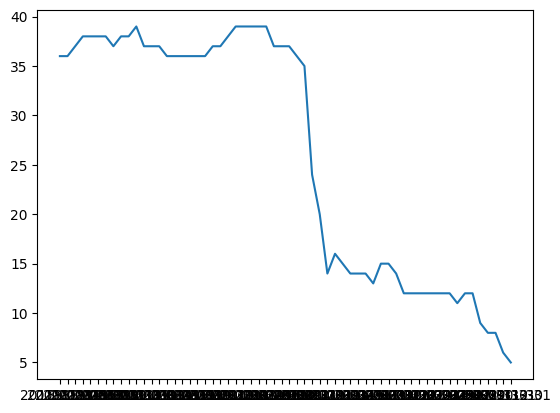

In [ ]:
import matplotlib.pyplot as plt

plt.plot(gdf['Date'],gdf['Default_flag'])

In [ ]:
df = df[(df['Date']>='2018-01-31')&(df['Date']<='2022-12-31')]

In [ ]:
df.shape

(16002, 15)

<Axes: xlabel='Cash_ind_t', ylabel='Count'>

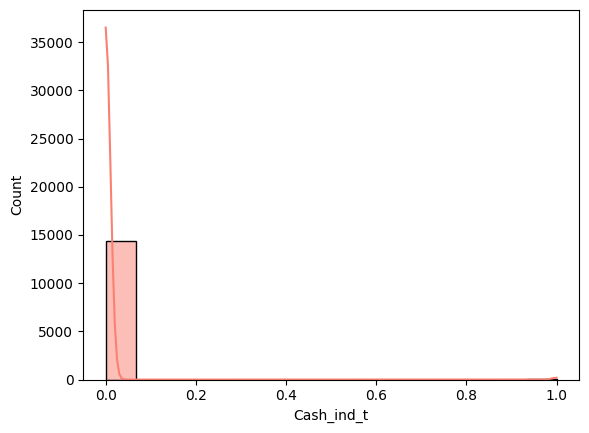

In [ ]:
import seaborn as sns
sns.histplot(data=df[df['Default_flag']==0], x='Cash_ind_t', kde=True, color='salmon')

<Axes: xlabel='Default_flag', ylabel='Count'>

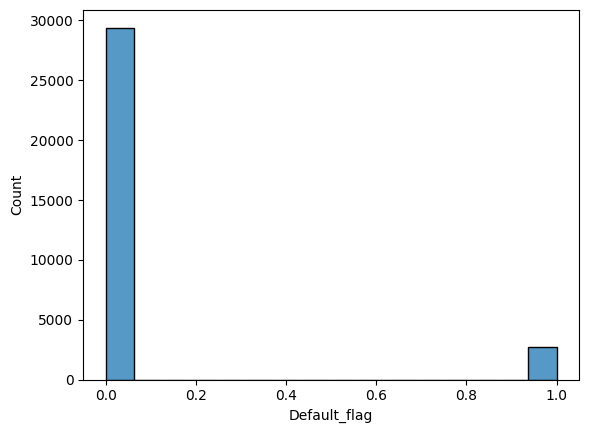

In [ ]:
sns.histplot(data=df, x='Default_flag')

In [ ]:
grouped_df = df.groupby('Date')[['Close_flag','Default_flag','TDR_flag','Cash_ind_t']].sum().reset_index()

In [ ]:
grouped_df['quarter'] = grouped_df['Date'].dt.to_period('Q')

# Snapshot and append data creation

In [62]:
df[['Date','Open_date','Close_date','Default_date']] = df[['Date','Open_date','Close_date','Default_date']].apply(pd.to_datetime)

In [10]:
snaps = df.groupby('qtr')['Date'].agg(lambda x: np.random.choice(x)).reset_index()

In [11]:
import calendar

append_data = pd.DataFrame()
for acct in df['ID'].unique():
    for date in snaps['Date']:
        data_chunk = df[(df['Date'] == date) & (df['ID'] == acct)]
        if not data_chunk.empty:
            end_date = date.replace(day=calendar.monthrange(date.year, date.month)[1]) + pd.DateOffset(months=39)
            data_chunk = df[(df['Date'] >= date) & (df['Date'] <= end_date) & (df['ID'] == acct)]
            if not data_chunk.empty:
                data_chunk = data_chunk.copy()  # Make a deep copy
                data_chunk['snap_month'] = date
                append_data = pd.concat([append_data,data_chunk], ignore_index=True)


In [12]:
append_data.shape

(106918, 18)

In [13]:
append_data['pf_month'] = (append_data['Date'].dt.year - append_data['snap_month'].dt.year) * 12 + (append_data['Date'].dt.month - append_data['snap_month'].dt.month)

In [14]:
append_data['pf_qtr'] =  (append_data['Date'].dt.year - append_data['snap_month'].dt.year) * 4 + (append_data['Date'].dt.quarter - append_data['snap_month'].dt.quarter)

In [15]:
#Encoding

In [16]:
append_data['db1pm15'] = ((append_data['Del_bucket_t'] == 1) & (append_data['pf_month'].isin(range(1,6)))).astype(int)
append_data['db1pm6'] = ((append_data['Del_bucket_t'] == 1) & (append_data['pf_month'] == 6)).astype(int)

append_data['db2pm14'] = ((append_data['Del_bucket_t'] == 2) & (append_data['pf_month'].isin(range(1,5)))).astype(int)
append_data['db2pm5'] = ((append_data['Del_bucket_t'] == 2) & (append_data['pf_month'] == 5)).astype(int)
append_data['db2pm6'] = ((append_data['Del_bucket_t'] == 2) & (append_data['pf_month'] == 6)).astype(int)

append_data['db3pm13'] = ((append_data['Del_bucket_t'] == 3) & (append_data['pf_month'].isin(range(1,4)))).astype(int)
append_data['db3pm4'] = ((append_data['Del_bucket_t'] == 3) & (append_data['pf_month'] == 4)).astype(int)
append_data['db3pm56'] = ((append_data['Del_bucket_t'] == 3) & (append_data['pf_month'].isin([5,6]))).astype(int)

append_data['db4pm12'] = ((append_data['Del_bucket_t'] == 4) & (append_data['pf_month'].isin([1,2]))).astype(int)
append_data['db4pm3'] = ((append_data['Del_bucket_t'] == 4) & (append_data['pf_month'] == 3)).astype(int)

append_data['db5pm1'] = ((append_data['Del_bucket_t'] == 5) & (append_data['pf_month'] == 1)).astype(int)
append_data['db5pm2'] = ((append_data['Del_bucket_t'] == 5) & (append_data['pf_month'] == 2)).astype(int)
append_data['db5pm3'] = ((append_data['Del_bucket_t'] == 5) & (append_data['pf_month'] == 3)).astype(int)

append_data['db6pm1'] = ((append_data['Del_bucket_t'] == 6) & (append_data['pf_month'] == 1)).astype(int)
append_data['db6pm2'] = ((append_data['Del_bucket_t'] == 6) & (append_data['pf_month'] == 2)).astype(int)
append_data['db6pm3'] = ((append_data['Del_bucket_t'] == 6) & (append_data['pf_month'] == 3)).astype(int)

In [17]:
append_data['cbpq1'] = ((append_data['Del_bucket_t'] == 0) & (append_data['pf_qtr'] == 1)).astype(int)
append_data['cbpq2'] = ((append_data['Del_bucket_t'] == 0) & (append_data['pf_qtr'] == 2)).astype(int)
append_data['cbpq3'] = ((append_data['Del_bucket_t'] == 0) & (append_data['pf_qtr'] == 3)).astype(int)

append_data['db1pq34'] = ((append_data['Del_bucket_t'] == 1) & (append_data['pf_qtr'].isin([3,4]))).astype(int)
append_data['db1pq4pls'] = ((append_data['Del_bucket_t'] == 1) & (append_data['pf_qtr'] > 4)).astype(int)

append_data['db2pq34'] = ((append_data['Del_bucket_t'] == 2) & (append_data['pf_qtr'].isin([3,4]))).astype(int)
append_data['db2pq4pls'] = ((append_data['Del_bucket_t'] == 2) & (append_data['pf_qtr'] > 4)).astype(int)

append_data['db3pq34'] = ((append_data['Del_bucket_t'] == 3) & (append_data['pf_qtr'].isin([3,4]))).astype(int)
append_data['db3pq4pls'] = ((append_data['Del_bucket_t'] == 3) & (append_data['pf_qtr'] > 4)).astype(int)

append_data['db4pq24'] = ((append_data['Del_bucket_t'] == 4) & (append_data['pf_qtr'].isin([2,4]))).astype(int)
append_data['db4pq4pls'] = ((append_data['Del_bucket_t'] == 4) & (append_data['pf_qtr'] > 4)).astype(int)

append_data['db5pq24'] = ((append_data['Del_bucket_t'] == 5) & (append_data['pf_qtr'].isin([2,4]))).astype(int)
append_data['db5pq4pls'] = ((append_data['Del_bucket_t'] == 5) & (append_data['pf_qtr'] > 4)).astype(int)

append_data['db6pq24'] = ((append_data['Del_bucket_t'] == 6) & (append_data['pf_qtr'].isin([2,4]))).astype(int)
append_data['db6pq4pls'] = ((append_data['Del_bucket_t'] == 6) & (append_data['pf_qtr'] > 4)).astype(int)


In [ ]:
#tss_vars = append_data.iloc[:,-31:]
# qss_vars = tss_vars.iloc[:,-15:]
# mss_vars = tss_vars.iloc[:,:16]

In [18]:
append_data.to_csv(r'/content/drive/MyDrive/modeling/append_data.csv')

Macro sensitivity and it's addition to data

In [19]:
mev = pd.read_excel(r'/content/drive/MyDrive/modeling/MEV.xlsx')

In [ ]:
mev.columns

Index(['Unnamed: 0', 'observation_date', 'qtr', 'GDPC1', 'NASDAQCOM', 'UNRATE',
       'GDP QoQ', 'eqity_qoq%', 'eqity_yoy%', 'eqity_qoq_diff', 'gdp_qoq_diff',
       'gdp_qoq%', 'eqity_yoy%_l6', 'gdp_qoq%_l12', 'gdp_qoq%_l6', 'quarter'],
      dtype='object')

In [20]:
mev['eqity_yoy%_l6'] = mev['eqity_yoy%'].shift(2)

In [21]:
mev['gdp_qoq%_l12'] = mev['gdp_qoq%'].shift(4)

In [22]:
mev['gdp_qoq%_l6'] = mev['gdp_qoq%'].shift(2)

In [23]:
mev['quarter'] = mev['observation_date'].dt.to_period('Q')

In [ ]:
mev

,Unnamed: 0,observation_date,qtr,GDPC1,NASDAQCOM,UNRATE,GDP QoQ,eqity_qoq%,eqity_yoy%,eqity_qoq_diff,gdp_qoq_diff,gdp_qoq%,eqity_yoy%_l6,gdp_qoq%_l12,gdp_qoq%_l6,quarter
0,0,2000-01-01,2000Q1,13878.147,4427.873492,4.033333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000Q1
1,1,2000-04-01,2000Q2,14130.908,3747.218571,3.933333,0.018213,-0.153720,NaN,-680.654921,252.761,0.018213,NaN,NaN,NaN,2000Q2
2,2,2000-07-01,2000Q3,14145.312,3933.188413,4.000000,0.001019,0.049629,NaN,185.969841,14.404,0.001019,NaN,NaN,NaN,2000Q3
3,3,2000-10-01,2000Q4,14229.765,3026.412857,3.900000,0.005970,-0.230545,NaN,-906.775556,84.453,0.005970,NaN,NaN,0.018213,2000Q4
4,4,2001-01-01,2001Q1,14183.120,2355.525161,4.233333,-0.003278,-0.221678,-0.468023,-670.887696,-46.645,-0.003278,NaN,NaN,0.001019,2001Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,89,2022-04-01,2022Q2,21708.160,12195.240000,3.600000,-0.001413,-0.128950,-0.119326,-1805.379839,-30.711,-0.001413,0.287455,0.015197,0.016968,2022Q2
90,90,2022-07-01,2022Q3,21851.134,11891.069844,3.566667,0.006586,-0.024942,-0.198713,-304.170156,142.974,0.006586,0.048621,0.008144,-0.004977,2022Q3
91,91,2022-10-01,2022Q4,21989.981,10871.376032,3.600000,0.006354,-0.085753,-0.293644,-1019.693812,138.847,0.006354,-0.119326,0.016968,-0.001413,2022Q4
92,92,2023-01-01,2023Q1,22112.329,11481.441129,3.500000,0.005564,0.056117,-0.179933,610.065097,122.348,0.005564,-0.198713,-0.004977,0.006586,2023Q1


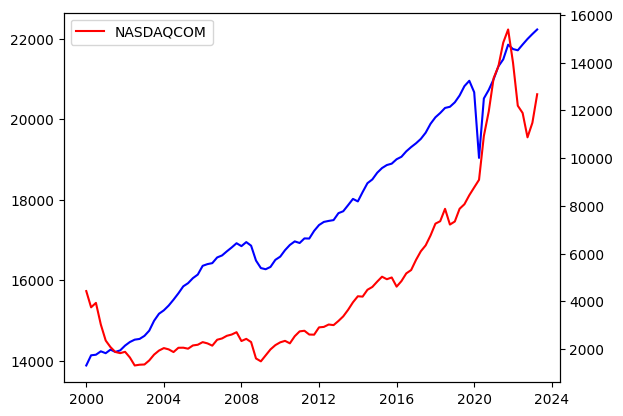

In [42]:
import matplotlib.pyplot as plt

plt.plot(mev['observation_date'], mev['GDPC1'], color='blue', label='GDPC1')
plt.twinx()
plt.plot(mev['observation_date'], mev['NASDAQCOM'], color='red', label='NASDAQCOM')

plt.legend()

In [64]:
grouped_df = df[df['Default_date']==df['Date']].groupby('Date')['ID'].count()


In [65]:
grouped_df

Date
2018-08-31     1
2018-12-31     2
2019-03-31     1
2020-05-31     2
2020-08-31     1
2020-09-30     1
2020-10-31    11
2020-11-30     4
2020-12-31     6
2021-02-28     1
2021-03-31     1
2021-06-30     1
2021-07-31     1
2021-09-30     1
2021-10-31     2
2022-05-31     1
2022-08-31     3
2022-09-30     1
2022-11-30     2
2022-12-31     1
Name: ID, dtype: int64

In [24]:
panel_data = pd.merge(append_data, mev, on = 'qtr', how= 'left')

In [25]:
panel_data['FICO_high'] = panel_data['FICO_Origion'].apply(lambda x: 1 if x > 650 else 0)
panel_data['FICO_med'] = panel_data['FICO_Origion'].apply(lambda x: 1 if 500 <= x <= 650 else 0)
panel_data['FICO_low'] = panel_data['FICO_Origion'].apply(lambda x: 1 if x < 500 else 0)

In [26]:
panel_data['util_high'] = panel_data['util'].apply(lambda x: 1 if x > 0.95 else 0)
panel_data['util_mid'] = panel_data['util'].apply(lambda x: 1 if 0.75 <= x <= 0.95 else 0)
#panel_data['FICO_low'] = panel_data['FICO_Origion'].apply(lambda x: 1 if x < 500 else 0)

In [27]:
panel_data.columns

Index(['ID', 'Date', 'qtr', 'Open_date', 'Close_date', 'Default_date',
       'TDR_flag', 'Cash_ind_t', 'FICO_Origion', 'ENR', 'util', 'MOB_t',
       'early_MOB_12_t', 'Close_flag', 'Default_flag', 'Del_bucket_t',
       'ENRutil', 'snap_month', 'pf_month', 'pf_qtr', 'db1pm15', 'db1pm6',
       'db2pm14', 'db2pm5', 'db2pm6', 'db3pm13', 'db3pm4', 'db3pm56',
       'db4pm12', 'db4pm3', 'db5pm1', 'db5pm2', 'db5pm3', 'db6pm1', 'db6pm2',
       'db6pm3', 'cbpq1', 'cbpq2', 'cbpq3', 'db1pq34', 'db1pq4pls', 'db2pq34',
       'db2pq4pls', 'db3pq34', 'db3pq4pls', 'db4pq24', 'db4pq4pls', 'db5pq24',
       'db5pq4pls', 'db6pq24', 'db6pq4pls', 'Unnamed: 0', 'observation_date',
       'GDPC1', 'NASDAQCOM', 'UNRATE', 'GDP QoQ', 'eqity_qoq%', 'eqity_yoy%',
       'eqity_qoq_diff', 'gdp_qoq_diff', 'gdp_qoq%', 'eqity_yoy%_l6',
       'gdp_qoq%_l12', 'gdp_qoq%_l6', 'quarter', 'FICO_high', 'FICO_med',
       'FICO_low', 'util_high', 'util_mid'],
      dtype='object')

# Model

In [35]:
beh_vars = ['TDR_flag', 'Cash_ind_t', 'early_MOB_12_t',
            "FICO_high", "FICO_med", "util_high", "util_mid"]
mss_vars = ['db1pm15', 'db1pm6', 'db2pm14', 'db2pm5', 'db2pm6', 'db3pm13', 'db3pm4',
       'db3pm56', 'db4pm12', 'db4pm3', 'db5pm1', 'db5pm2', 'db5pm3', 'db6pm1',
       'db6pm2', 'db6pm3', 'cbpq1', 'cbpq2', 'cbpq3', 'db1pq34', 'db1pq4pls',
       'db2pq34', 'db2pq4pls', 'db3pq34', 'db3pq4pls', 'db4pq24', 'db4pq4pls',
       'db5pq24', 'db5pq4pls', 'db6pq24', 'db6pq4pls']
mevs = ['gdp_qoq%_l6', 'eqity_yoy%_l6']

In [51]:
# Extract the independent variables and the target variable
#X = panel_data[beh_vars+mss_vars+mevs]
X = panel_data[beh_vars+mevs]
y = panel_data['Default_flag']


In [52]:
from sklearn.linear_model import LogisticRegression

# Create a logistic regression model
model = LogisticRegression(solver='lbfgs')

# Fit the model on the data
model.fit(X, y)

# Extract the coefficients and intercept from the fitted model
new_coefficients = model.coef_[0]
new_intercept = model.intercept_[0]

#print("Fitted Intercept:", new_intercept)

# Create a DataFrame to map coefficients to feature names
coefficients_df = pd.DataFrame({'Variable': X.columns, 'Coeff': new_coefficients})
#print(coefficients_df)
coefficients_df = coefficients_df.append({'Variable':'intercept','Coeff':new_intercept}, ignore_index=True)

<ipython-input-52-f9c6a9426ee4>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefficients_df = coefficients_df.append({'Variable':'intercept','Coeff':new_intercept}, ignore_index=True)


In [53]:
variable_names = ["gdp_qoq%_l6", "eqity_yoy%_l6",
                  "vintage141516", "TDR_flag", "early_MOB_12_t", "Cash_ind_t",
                  "cbpq1", "cbpq2", "cbpq3",
                  "db1pm15","db1pm6","db1pq34","db1pq4pls",
                  "db2pm14","db2pm5","db2pm6","db2pq34","db2pq4pls",
                  "db3pm13","db3pm4","db3pm56","db3pq34","db3pq4pls",
                  "db4pm12","db4pm3","db4pq24","db4pq4pls",
                  "db5pm1","db5pm2","db5pm3","db5pq24","db5pq4pls",
                  "db6pm1","db6pm2","db6pm3","db6pq24","db6pq4pls",
                  "FICO_high", "FICO_med", "FICO_low",
                  "util_high", "util_mid"]
coefficients = [-20.2364, -0.523,
                0.3755, 1.0747, 0.448, 0.2037,
                -4.8226, -4.0543, -0.2012,
                -2.4151, 2.4193, 1.094, 0.7414,
                -1.4502, 3.5919, 2.1074, 1.7916, 1.247,
                -0.8929, 4.2762, 2.6056, 2.1035, 1.3664,
                -0.5817, 4.881, 2.6827, 1.4516,
                -1.1824, 5.263, 3.5918, 2.7167, 1.4128,
                6.1143, 3.9237, 3.52, 2.7408, 1.5474,
                -0.1382, 0.1608, 0.2074,
                1.6337, 1.2283]

In [54]:
ref = pd.DataFrame({'Variable': variable_names, 'Coeff': coefficients})

In [55]:
ref = ref.append({'Variable':'intercept','Coeff':-6.209}, ignore_index=True)

<ipython-input-55-72fa3ae5c738>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ref = ref.append({'Variable':'intercept','Coeff':-6.209}, ignore_index=True)


In [56]:
pd.merge(coefficients_df,ref, on='Variable', how='left')

,Variable,Coeff_x,Coeff_y
0,TDR_flag,3.854657,1.0747
1,Cash_ind_t,3.158810,0.2037
2,early_MOB_12_t,-0.170640,0.4480
3,FICO_high,-0.898256,-0.1382
4,FICO_med,1.111467,0.1608
5,util_high,2.981438,1.6337
6,util_mid,1.604998,1.2283
7,gdp_qoq%_l6,-0.320918,-20.2364
8,eqity_yoy%_l6,-2.197216,-0.5230
9,intercept,-3.467403,-6.2090
